In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 2.1 MB/s 
     |████████████████████████████████| 163 kB 74.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data as data
from torchsummary import summary

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [ ]:
# general global variables
MODEL_NAME = "ViT"
CASE_NAME = "rice"
path_folder = "/content/drive/MyDrive/AI/AI projects/Rice disease"

DATA_PATH = "/content/drive/MyDrive/AI/data/new_rice_disease_data"
MODEL_PRETRAINED_PATH = "/content/drive/MyDrive/AI/AI projects/Rice disease/ViT/jx_vit_base_p16_224-80ecf9dd.pth"
MODEL_PATH = "/content/drive/MyDrive/AI/AI projects/Rice disease/ViT/ViT_244x244_16.pth"

# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 50
DICT_CLASS = {'brownSpot': 0, 'healthy': 1, 'hispa': 2, 'leafblast': 3}

In [ ]:
def shuffle2List(l1, l2):
  temp = list(zip(l1, l2))
  random.shuffle(temp)
  res1, res2 = zip(*temp)
  # res1 and res2 come out as tuples, and so must be converted to lists.
  res1, res2 = list(res1), list(res2)
  return res1, res2

def make_datapath_lst(rootpath):

  train_img_lst = list()
  train_label_lst = list()
  val_img_lst = list()
  val_label_lst = list()

  for folder in os.listdir(rootpath):
    if not folder.endswith(".zip"):
      img_lst = os.listdir(os.path.join(rootpath, folder))
      random.shuffle(img_lst)
      thread_ = int(len(img_lst)*0.8)
      train_img_lst.extend(img_lst[:thread_])
      train_label_lst.extend([folder]*len(img_lst[:thread_]))
      val_img_lst.extend(img_lst[thread_:])
      val_label_lst.extend([folder]*len(img_lst[thread_:]))
  
  # train_img_lst, train_label_lst = shuffle2List(train_img_lst, train_label_lst)
  # val_img_lst, val_label_lst = shuffle2List(val_img_lst, val_label_lst)

  return train_img_lst, train_label_lst, val_img_lst, val_label_lst

In [ ]:
class Compose():
  def __init__(self, transforms) -> None:
    self.transforms = transforms

  def __call__(self, img):
    for t in self.transforms:
      img = t(img)
    return img

In [ ]:
class RandomMirror():
  def __call__(self, img):
    if np.random.randint(2):
      img = ImageOps.mirror(img)
    return img

In [ ]:
class Resize():
  def __init__(self, size):
    self.size = size

  def __call__(self, img):
    img = img.resize((self.size, self.size), Image.BILINEAR)
    return img

In [ ]:
class Normalize_Tensor():
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, img):
    img = transforms.functional.to_tensor(img)
    img = transforms.functional.normalize(img, self.mean, self.std)
    return img

In [ ]:
class DataTransform():
  def __init__(self, size, mean, std):
    self.data_tranform = {
        "train": Compose([
            RandomMirror(),
            Resize(size),
            Normalize_Tensor(mean, std)
        ]),
        "val": Compose([
            Resize(size),
            Normalize_Tensor(mean, std)
        ])
    }

  def __call__(self, phase, img):
    return self.data_tranform[phase](img)

In [ ]:
class MyDataset(data.Dataset):
  def __init__(self,img_lst, label_lst, phase, transform):
    super().__init__()
    self.img_lst = img_lst
    self.label_lst = label_lst
    self.phase = phase
    self.transform = transform

  def __len__(self):
    return len(self.img_lst)

  def __getitem__(self, idx):
    img, label = self.pull_item(idx)
    return img, label

  def pull_item(self, idx):
    label = self.label_lst[idx]
    img_file_path = os.path.join(DATA_PATH, label, self.img_lst[idx])
    img = Image.open(img_file_path)
    img_rgb = img.convert('RGB')
    img_transformed = self.transform(self.phase, img_rgb)
    return img_transformed, DICT_CLASS[label]

In [ ]:
def test_data():
  train_img_list, train_label_list, val_img_list, val_label_list = make_datapath_lst(DATA_PATH)

  print(len(train_img_list))
  print(len(val_img_list))

  color_mean = (0.485, 0.456, 0.406)
  color_std = (0.229, 0.224, 0.225)

  train_dataset = MyDataset(train_img_list, train_label_list, phase="train", transform=DataTransform(size=IMG_SIZE, mean=color_mean, std=color_std))
  val_dataset = MyDataset(val_img_list, val_label_list, phase="val", transform=DataTransform(size=IMG_SIZE, mean=color_mean, std=color_std))

  img, label = train_dataset.__getitem__(1)
  img = img.numpy().transpose(1,2,0) #(chanel(RGB), height, witdh) => (height, width, channel(RGB))
  plt.imshow(img)
  plt.title(label)
  plt.show()

  batch_size = 32
  train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  dataloader_dict = {
      "train": train_dataloader,
      "val": val_dataloader
  }

  batch_iterator = iter(dataloader_dict["train"])

  images, labels = next(batch_iterator)

  image = images[0].numpy().transpose(1,2,0) #(chanel(RGB), height, witdh) => (height, width, channel(RGB))
  plt.imshow(image)
  plt.title(labels[0])
  plt.show()

  image = images[1].numpy().transpose(1,2,0)
  plt.imshow(image)
  plt.title(labels[1])
  plt.show()

5837
1461


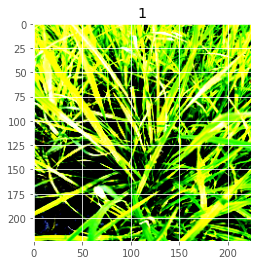

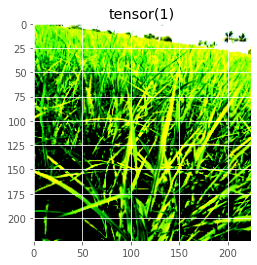

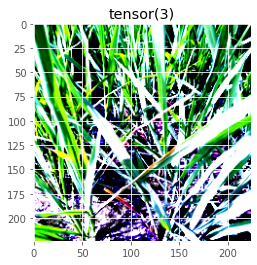

In [ ]:
test_data()

In [ ]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_224_clip_laion2b',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_clip_laion2b',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_

In [ ]:
class ViTBase16(nn.Module):
  def __init__(self, n_classes, pretrained=False):
    super(ViTBase16, self).__init__()

    self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
    if pretrained:
      self.model.load_state_dict(torch.load(MODEL_PRETRAINED_PATH))
    
    self.model.head = nn.Linear(self.model.head.in_features, n_classes)

  def forward(self, x):
    x = self.model(x)
    return x

  def train_one_epoch(self, train_loader, criterion, optimizer, device):
    # keep track of training loss
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    ###################
    # train the model #
    ###################
    self.model.train()
    for i, (data, target) in enumerate(train_loader):
      # move tensors to GPU if CUDA is available
      if device.type == "cuda":
        data, target = data.cuda(), target.cuda()

      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = self.forward(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # Calculate Accuracy
      accuracy = (output.argmax(dim=1) == target).float().mean()
      # update training loss and accuracy
      epoch_loss += loss
      epoch_accuracy += accuracy

      optimizer.step()
      print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

    return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

  def validate_one_epoch(self, valid_loader, criterion, device):
    # keep track of validation loss
    valid_loss = 0.0
    valid_accuracy = 0.0

    ######################
    # validate the model #
    ######################
    self.model.eval()
    for data, target in valid_loader:
      # move tensors to GPU if CUDA is available
      if device.type == "cuda":
        data, target = data.cuda(), target.cuda()

      with torch.no_grad():
        # forward pass: compute predicted outputs by passing inputs to the model
        output = self.model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # Calculate Accuracy
        accuracy = (output.argmax(dim=1) == target).float().mean()
        # update average validation loss and accuracy
        valid_loss += loss
        valid_accuracy += accuracy

    return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
def fit_(model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):

    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()

        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")

        # train_loader, criterion, optimizer, device
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
              print(
                  "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                      valid_loss_min, valid_loss
                  )
              )
              torch.save(model.state_dict(), MODEL_PATH)

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [ ]:
model = ViTBase16(n_classes=4, pretrained=True)

In [ ]:
def _run():
  train_img_list, train_label_list, val_img_list, val_label_list = make_datapath_lst(DATA_PATH)

  color_mean = (0.485, 0.456, 0.406)
  color_std = (0.229, 0.224, 0.225)

  train_dataset = MyDataset(train_img_list, train_label_list, phase="train", transform=DataTransform(size=IMG_SIZE, mean=color_mean, std=color_std))
  val_dataset = MyDataset(val_img_list, val_label_list, phase="val", transform=DataTransform(size=IMG_SIZE, mean=color_mean, std=color_std))

  batch_size = 64
  train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)

  print(f"INITIALIZING TRAINING ON {device}")
  start_time = datetime.now()
  print(f"Start Time: {start_time}")

  logs = fit_(
      model=model,
      epochs=N_EPOCHS,
      device=device,
      criterion=criterion,
      optimizer=optimizer,
      train_loader=train_dataloader,
      valid_loader=val_dataloader,
  )

  print(f"Execution time: {datetime.now() - start_time}")
  print("Saving Model")

  torch.save(model.state_dict(), f'/content/drive/MyDrive/AI/AI projects/Rice disease/ViT/ViT_244x244_16_pre.pth')
  print("ALL DONE!!!")

In [ ]:
def _calculate_f1_core():

  train_img_list, train_label_list, val_img_list, val_label_list = make_datapath_lst(DATA_PATH)

  color_mean = (0.485, 0.456, 0.406)
  color_std = (0.229, 0.224, 0.225)

  batch_size = 64
  val_dataset = MyDataset(val_img_list, val_label_list, phase="val", transform=DataTransform(size=IMG_SIZE, mean=color_mean, std=color_std))
  val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  valid_accuracy = 0.0

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.load_state_dict(torch.load(MODEL_PATH))
  model.to(device)
  model.eval()

  res, true_res = [], []

  f1 = F1Score(num_classes=4, average='macro')
  for data_input, target in val_dataloader:
    # move tensors to GPU if CUDA is available
    # if device.type == "cuda":
    data_input, target = data_input.to(device), target.to(device)

    with torch.no_grad():

      output = model(data_input)
      # loss = criterion(output, target)
      accuracy = (output.argmax(dim=1) == target).float().mean()
      valid_accuracy += accuracy
      res.extend(np.argmax(output.cpu().data.numpy(), axis=1))
      true_res.extend(target.cpu().data.numpy())
    # break
  return res, true_res

In [ ]:
# Calculate F1-score
res, true_res = _calculate_f1_core()

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(true_res, res, average='macro'))

0.9536765326758334


In [ ]:
# Start training processes
# _run()

In [ ]:
# model = timm.create_model("vit_base_patch16_224", pretrained=True)

In [ ]:
model.cuda()
summary(model, (3, 224, 224))

In [ ]:
def predict(image):

  IMG_SIZE = 224
  color_mean = (0.485, 0.456, 0.406)
  color_std = (0.229, 0.224, 0.225)
  transform_pre = DataTransform(size=IMG_SIZE, mean=color_mean, std=color_std)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.load_state_dict(torch.load(MODEL_PATH))
  model.to(device)
  model.eval()
  

  image = transform_pre('val', image).unsqueeze(0)
  image = image.to(device)

  output = model(image)
  print(output)
  return output

In [ ]:
image = Image.open('/content/drive/MyDrive/AI/data/new_rice_disease_data/healthy/100002.jpg')
pre_label = predict(image)

tensor([[-3.7918,  6.4246, -1.5947, -1.4426]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
model = ViTBase16(n_classes=4, pretrained=True)
model.load_state_dict(torch.load(MODEL_PATH))
torch.save(model, "/content/drive/MyDrive/AI/AI projects/Rice disease/ViT/ViT_model_244x244_16.pt")

In [ ]:
os.path.exists('/content/drive/MyDrive/AI/AI projects/Rice disease/ViT/ViT_model_244x244_16.pt')

True

In [ ]:

torch.device('cuda:0')

device(type='cuda', index=0)

In [ ]:
class ViTBase16(nn.Module):
  def __init__(self, n_classes):
    super(ViTBase16, self).__init__()

    self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
    self.model.head = nn.Linear(self.model.head.in_features, n_classes)
    
  def forward(self, x):
    x = self.model(x)
    return x

In [ ]:
PATH = '/content/drive/MyDrive/AI/AI projects/Rice disease/ViT/ViT_244x244_16.pth'
device = torch.device(device="cuda")
model = ViTBase16(n_classes=4)
# print(model)
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()


ViTBase16(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=3072, out_